# 📘 Proyecto de Aula - Fundamentos en Ciencia de Datos

*"Análisis del comportamiento e identificación de patrones en el valor de las donaciones de una empresa del sector cárnico mediante técnicas de ciencia de datos"*

**Objetivo**
•	Estandarizar el conjunto de datos mediante la imputación de valores faltantes, el escalamiento de variables y la aplicación de transformaciones adecuadas, asegurando un preprocesamiento que mejore la interpretabilidad y desempeño de los modelos analíticos posteriores.

Importar librerías

In [ ]:
# Librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Instalar librerías necesarias
!pip install pingouin seaborn
!pip install pandas numpy seaborn matplotlib scikit-learn openpyxl --quiet

# Importar bibliotecas
import numpy as np
import pingouin as pg
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.stats import boxcox
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
import warnings
from sklearn.preprocessing import OneHotEncoder




[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Lectura de datos

In [135]:
# Datos
import pandas as pd

# Leer el archivo CSV (usa el nombre correcto)
df = pd.read_csv("df_nclean.csv")


# **8. Imputación, Escalamiento y Transformación**

# *Imputación de datos*

En primera instancia se procede a las imputaciones pendientes de secciones pasadas, que en este caso es la variable "material", con valores "0".

In [ ]:
# Análisis de valores iguales a 0
# Contar cuántos ceros hay en cada columna numérica
zero_counts = (df == 0).sum()

# Filtrar solo las columnas que tienen al menos un cero
zero_counts = zero_counts[zero_counts > 0].sort_values(ascending=False)

# Mostrar resultado
print("Variables con valores iguales a 0:\n")
print(zero_counts)

# Mostrar porcentaje de ceros en relación al total de filas
print("\nPorcentaje de valores 0:\n")
print((zero_counts / len(df) * 100).round(2))

Variables con valores iguales a 0:

cantidad          96679
material          43971
peso_kg            2665
desperdicio_kg      909
dtype: int64

Porcentaje de valores 0:

cantidad          5.35
material          2.43
peso_kg           0.15
desperdicio_kg    0.05
dtype: float64


De acuerdo con los resultados de los valores "0", pordemos ver que hay un gran número en la variable "material", que es el código de los productos donados, esta variable no debería tener estos valores, como ya se mencionó en secciones anteriores. Y las demás variables, tienen estos valores ("cluster_kmeans", "cantidad", "peso_kg" y "donacion_kg") por su naturaleza, así que no se hace necesario realizar la imputación.

La primera variable a imputar es "material" con la estrategia MAR — Missing at Random, ya que apartir de la relación directa con una tercera variable se pretende cambiar los valores ceros, que no deberían estar en ceros, según la naturaleza de la variable.

Para hacer la imputación con el df inicial, que es en dónde se encuentra la variable "Denominación" que es el nombre en letras del producto donado, se procede a eliminar los únicos datos que se han eliminado a lo largo del proceso, que son los de la variable "Valor" = 0, para que quede de la misma longitud. Y de esta manera, incluír esta variable en el df que se tiene actualemente para hacer la respectiva imputación.

In [137]:
# ==============================
# Imputación de 'material' según 'denominacion'
# ==============================

# Crear una copia del df original
df_imputado = df.copy()

# Crear un diccionario que relacione cada denominacion con su material válido (≠ 0)
mapa_material = (
    df_imputado.loc[df_imputado['material'] != 0, ['nombre_material', 'material']]
    .drop_duplicates(subset='nombre_material')
    .set_index('nombre_material')['material']
    .to_dict()
)

# Reemplazar los ceros de material usando la denominacion
df_imputado['material'] = df_imputado.apply(
    lambda row: mapa_material.get(row['nombre_material'], row['material'])
    if row['material'] == 0 else row['material'],
    axis=1
)

# ==============================
# Verificación
# ==============================

# Mostrar cuántos valores quedaron aún como 0
faltantes = (df_imputado['material'] == 0).sum()
print(f"Valores que permanecen en 0 después de la imputación: {faltantes}")

# Mostrar los primeros registros
df_imputado[['nombre_material', 'material']].head()


Valores que permanecen en 0 después de la imputación: 0


,nombre_material,material
0,lomos atun zenu en aceite girasol x 120g,2031253
1,mortadela rapiya precocida cunit x 450g,1075038
2,maiz dulce zenu x 241 g,2011706
3,picada mixta lomo y tocino ranchera 500g,1079335
4,mtdela. zenu pll. x 250 g,1000571


Adicionalmente, hay unas variables que tienen valores '0' como texto y que sugiere un análisis diferente.

In [ ]:
# Análisis de valores iguales a 0 después de la imputación
# Contar cuántos ceros hay en cada columna 
zero_counts = (df_imputado == '0').sum()

# Filtrar solo las columnas que tienen al menos un cero
zero_counts = zero_counts[zero_counts > 0].sort_values(ascending=False)

# Mostrar resultado
print("Variables con valores iguales a 0:\n")
print(zero_counts)

# Mostrar porcentaje de ceros en relación al total de filas
print("\nPorcentaje de valores 0:\n")
print((zero_counts / len(df_imputado) * 100).round(2))

Variables con valores iguales a 0:

categoria       9452
subcategoria    9401
marca           9392
linea           8529
planta          1054
tipo              79
dtype: int64

Porcentaje de valores 0:

categoria       0.52
subcategoria    0.52
marca           0.52
linea           0.47
planta          0.06
tipo            0.00
dtype: float64


El campo "causales" con categoría '0' es lógico dentro del contexto, ya que allí se encuentran caracterizadas todas las donaciones generadas por el motivo de "productos nuevos", como no hay un código que los identifique, utilizan el '0' como una diferenciación, por el contrario, las demás variables si deben ser imputadas.

In [ ]:
# ==============================
# Imputación de variables categóricas según 'material'
# ==============================
# Crear una copia del DataFrame original
df_imput2 = df_imputado.copy()

# Lista de variables a imputar
variables_a_imputar = ['categoria', 'subcategoria', 'marca', 'linea', 'planta']

# Crear diccionarios de moda por 'material' para cada variable (ignorando los '0' en texto)
mapas_por_material = {}
for var in variables_a_imputar:
    df_validos = df_imput2[
        (df_imput2['material'] != '0') &
        (df_imput2[var] != '0') &
        (~df_imput2['material'].isna())
    ]

    if not df_validos.empty:
        mapa = (
            df_validos.groupby('material')[var]
            .agg(lambda x: x.mode()[0] if not x.mode().empty else None)
            .to_dict()
        )
        mapas_por_material[var] = mapa
    else:
        mapas_por_material[var] = {}

# Aplicar la imputación (solo cuando el valor sea el texto '0')
for var in variables_a_imputar:
    df_imput2[var] = df_imput2.apply(
        lambda row: mapas_por_material[var].get(row['material'], row[var])
        if row[var] == '0' else row[var],
        axis=1
    )

    ceros_restantes = (df_imput2[var] == '0').sum()
    print(f"Valores '0' restantes en '{var}' después de la imputación: {ceros_restantes}")

Valores '0' restantes en 'categoria' después de la imputación: 1550
Valores '0' restantes en 'subcategoria' después de la imputación: 1495
Valores '0' restantes en 'marca' después de la imputación: 1491
Valores '0' restantes en 'linea' después de la imputación: 1493
Valores '0' restantes en 'planta' después de la imputación: 1053


In [ ]:
# Análisis de valores iguales a 0 después de la segunda imputación
# Contar cuántos ceros hay en cada columna numérica
zero_counts = (df_imput2 == '0').sum()

# Filtrar solo las columnas que tienen al menos un cero
zero_counts = zero_counts[zero_counts > 0].sort_values(ascending=False)

# Mostrar resultado
print("Variables con valores iguales a 0:\n")
print(zero_counts)

# Mostrar porcentaje de ceros en relación al total de filas
print("\nPorcentaje de valores 0:\n")
print((zero_counts / len(df_imput2) * 100).round(2))

Variables con valores iguales a 0:

categoria       1550
subcategoria    1495
linea           1493
marca           1491
planta          1053
tipo              79
dtype: int64

Porcentaje de valores 0:

categoria       0.09
subcategoria    0.08
linea           0.08
marca           0.08
planta          0.06
tipo            0.00
dtype: float64


_**Se procede a imputar los restantes con la moda**_

In [ ]:
# ==============================
# Imputación de variables categóricas con moda global
# ==============================
# Crear una copia del DataFrame anterior
df_imput3 = df_imput2.copy()

# Lista de variables a imputar con su moda
variables_a_imputar = ['categoria', 'subcategoria', 'marca', 'linea', 'planta']

# Imputar solo cuando el valor sea el texto '0'
for var in variables_a_imputar:
    # Calcular la moda (ignorando los '0' en texto)
    moda = df_imput3.loc[df_imput3[var] != '0', var].mode()[0]
    
    # Reemplazar solo los '0' (texto)
    df_imput3[var] = df_imput3[var].apply(
        lambda x: moda if x == '0' else x
    )
    
    # Contar cuántos '0' quedan
    ceros_restantes = (df_imput3[var] == '0').sum()
    print(f"Variable '{var}': moda = {moda} | '0' restantes = {ceros_restantes}")


Variable 'categoria': moda = carnes frias | '0' restantes = 0
Variable 'subcategoria': moda = barras cortas  | '0' restantes = 0
Variable 'marca': moda = zenu | '0' restantes = 0
Variable 'linea': moda = salchicha | '0' restantes = 0
Variable 'planta': moda = medellin | '0' restantes = 0


Y se evidencia que quedaron todas las categóricas sin valores en '0'

De esta forma, como se pudo analizar en la etapa de "Descripción y Limpieza", hay una cantidad de datos nulos en las variables categóricas, en las que se van a aplicar estrategias de imputación, en lo posible, para su respectivo análisis y no llegar al extremo de eliminarlos.

In [ ]:
# Análisis de valores iguales a 0 después de la tercera imputación
# Contar cuántos ceros hay en cada columna numérica
# Mostrar conteo de valores nulos por columna
null_counts = df_imput3.isnull().sum()

# Filtrar solo las columnas que tienen nulos
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

# Mostrar resultado
print("Variables con datos nulos:\n")
print(null_counts)

# También puedes mostrar el porcentaje de nulos:
print("\nPorcentaje de valores nulos:\n")
print((null_counts / len(df_imput3) * 100).round(2))

Variables con datos nulos:

subcategoria       149799
linea               22636
marca               21306
categoria           19138
nombre_material       122
planta                 69
tipo                   69
dtype: int64

Porcentaje de valores nulos:

subcategoria       8.29
linea              1.25
marca              1.18
categoria          1.06
nombre_material    0.01
planta             0.00
tipo               0.00
dtype: float64


En primera medida se proceden a imputar por medio de los valores asignados a los materiales, que es una línea lógica, ya que todos los materiales deberían tener las misma especificaciones.

In [ ]:
# ==============================
# Imputación de variables categóricas según 'material' usando moda por material
# ==============================
df_imput4 = df_imput3.copy()

# Para cada columna excepto 'material'
for col in df_imput4.columns:
    if col == "material":
        continue

    # Calcular la moda por material (un valor por material)
    moda_por_material = df_imput4.groupby("material")[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

    # Imputar usando .apply fila por fila
    df_imput4[col] = df_imput4.apply(
        lambda row: moda_por_material[row["material"]] if pd.isna(row[col]) else row[col],
        axis=1
    )
# Mostrar conteo de valores nulos por columna
null_counts = df_imput4.isnull().sum()

In [ ]:
# Filtrar solo las columnas que tienen nulos
# Total de filas y columnas
total_filas = len(df_imput4)
total_columnas = df_imput4.shape[1]
total_celdas = total_filas * total_columnas

# --- 1. Calcular NaN por columna ---
nan_info = (
    df_imput4.isna().sum()
    .to_frame(name="num_nan")
)

# --- 2. Porcentaje por columna ---
nan_info["porcentaje"] = (nan_info["num_nan"] / total_filas) * 100

# --- 3. Filtrar columnas con NaN y ordenar ---
nan_info = nan_info[nan_info["num_nan"] > 0] \
             .sort_values("porcentaje", ascending=False)

# --- 4. Totales globales ---
total_nan_global = df_imput4.isna().sum().sum()
porcentaje_global = (total_nan_global / total_celdas) * 100

print("🔍 NaN por columna (ordenado):")
display(nan_info)

print("\n📌 Totales globales en el DataFrame:")
print(f"Total NaN en todo el DF: {total_nan_global:,}")
print(f"Porcentaje global de NaN sobre todas las celdas: {porcentaje_global:.2f}%")



🔍 NaN por columna (ordenado):


,num_nan,porcentaje
subcategoria,120639,6.676688
marca,20937,1.158745
linea,20295,1.123214
categoria,18871,1.044403
nombre_material,117,0.006475



📌 Totales globales en el DataFrame:
Total NaN en todo el DF: 180,859
Porcentaje global de NaN sobre todas las celdas: 0.71%


Ya que el total de los datos NAN menos del 1% se procede a eliminarlos, después de haber hecho la imputación correspondiente.

In [145]:
# 1. Valores NaN en todo el DataFrame
df_imput5 = df_imput4.dropna().copy()
df_imput5.isna().sum().sum()


np.int64(0)

_**Validar los '0' en el df_umput4**_

Si bien ya se limpió los ceros inicialmente, puede que hallan ceros como número o ceros como string, para segurar que todo quede ok, se procede a analizarlos.

In [ ]:
# Análisis de valores iguales a 0 después de la cuarta imputación

# --- 1. Detectar ceros numéricos y '0' como string ---
mask_zeros = (df_imput5 == 0) | (df_imput5 == '0')

# --- 2. Contar ceros por columna ---
conteo_zeros = mask_zeros.sum()

# --- 3. Calcular porcentaje por columna ---
total_filas = len(df_imput5)
porcentaje_zeros = (conteo_zeros / total_filas * 100).round(2)

# --- 4. Crear tabla resumen ---
reporte_zeros = pd.DataFrame({
    'conteo_zeros': conteo_zeros,
    'porcentaje': porcentaje_zeros
})

# --- 5. Ordenar de mayor a menor por cantidad de ceros ---
reporte_zeros = reporte_zeros.sort_values(by='conteo_zeros', ascending=False)

# --- 6. Calcular total general ---
total_zeros_global = mask_zeros.sum().sum()
porcentaje_global = round((total_zeros_global / (total_filas * df_imput5.shape[1])) * 100, 2)

print("\n🔍 **Ceros por columna (de mayor a menor):**")
display(reporte_zeros)

print("\n📌 **Totales globales:**")
print(f"Total de ceros (0 o '0') en todo el DF: {total_zeros_global:,}")
print(f"Porcentaje global frente al total de celdas: {porcentaje_global}%")



🔍 **Ceros por columna (de mayor a menor):**


,conteo_zeros,porcentaje
cantidad,84310,5.00
peso_kg,1278,0.08
desperdicio_kg,521,0.03
tipo,42,0.00
material,0,0.00
fecha,0,0.00
valor,0,0.00
planta,0,0.00
subcategoria,0,0.00
categoria,0,0.00



📌 **Totales globales:**
Total de ceros (0 o '0') en todo el DF: 86,151
Porcentaje global frente al total de celdas: 0.36%


Se procede a realizar la imputación con la moda de los valores que encuentre en la coincidencia exacta de la variable material.

In [ ]:
# ==============================
# Imputación de variables categóricas según 'material' usando moda por material
# ==============================
df = df_imput5.copy()  # NO modificar el original

# Asegurarse de que 'material' existe
if 'material' not in df.columns:
    raise ValueError("❌ La columna 'material' no existe en df_imput5.")

# Reemplazar 0 numérico y '0' string por NaN en todo el DF
df = df.replace(0, np.nan).replace("0", np.nan)

# Función para imputar por grupo (material)
def imputar_por_material(grupo):
    for col in grupo.columns:
        if col == 'material':
            continue
        
        # Hallar moda del grupo
        moda = grupo[col].mode(dropna=True)
        if not moda.empty:
            grupo[col] = grupo[col].fillna(moda.iloc[0])
        else:
            # Si el material no tiene datos válidos → usar moda global
            moda_global = df[col].mode(dropna=True)
            if not moda_global.empty:
                grupo[col] = grupo[col].fillna(moda_global.iloc[0])
    return grupo

# Aplicar imputación por material
df_imputado = df.groupby("material").apply(imputar_por_material)

# Quitar el multi-índice que genera el groupby
df_imputado = df_imputado.reset_index(drop=True)

# Resultado final
df_imput6 = df_imputado.copy()


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7132\1319820668.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imputado = df.groupby("material").apply(imputar_por_material)


Validación de modificación, antes y después de hacer las imputaciones.

In [148]:
# ===========================================
# ANÁLISIS COMPLETO DE VALORES NaN Y '0'
# ===========================================

print("🔍 ANÁLISIS DE VALORES NaN Y '0' EN EL DATAFRAME")
print("=" * 60)

# 1. Información general del DataFrame
print("1. INFORMACIÓN GENERAL:")
print(f"   - Dimensiones: {df_imput6.shape[0]} filas x {df_imput6.shape[1]} columnas")
print(f"   - Memoria usada: {df_imput6.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 2. Valores NaN por columna
print("\n2. VALORES NaN POR COLUMNA:")
nan_por_columna = df_imput6.isnull().sum()
nan_por_columna = nan_por_columna[nan_por_columna > 0]

if len(nan_por_columna) > 0:
    for col, count in nan_por_columna.items():
        porcentaje = (count / len(df_imput6)) * 100
        print(f"   - {col}: {count:,} NaN ({porcentaje:.2f}%)")
else:
    print("   ✅ No hay valores NaN en el DataFrame")

# 3. Valores '0' por columna (solo columnas numéricas)
print("\n3. VALORES '0' POR COLUMNA (numéricas):")
columnas_numericas = df_imput6.select_dtypes(include=[np.number]).columns

ceros_por_columna = {}
for col in columnas_numericas:
    ceros = (df_imput6[col] == 0).sum()
    if ceros > 0:
        ceros_por_columna[col] = ceros

if ceros_por_columna:
    for col, count in ceros_por_columna.items():
        porcentaje = (count / len(df_imput6)) * 100
        print(f"   - {col}: {count:,} ceros ({porcentaje:.2f}%)")
else:
    print("   ✅ No hay valores '0' en columnas numéricas")

# 4. Valores vacíos o strings vacíos en columnas categóricas
print("\n4. VALORES VACÍOS EN COLUMNAS CATEGÓRICAS:")
columnas_categoricas = df_imput6.select_dtypes(include=['object']).columns

vacios_por_columna = {}
for col in columnas_categoricas:
    vacios = (df_imput6[col] == '') | (df_imput6[col].isnull())
    count_vacios = vacios.sum()
    if count_vacios > 0:
        vacios_por_columna[col] = count_vacios

if vacios_por_columna:
    for col, count in vacios_por_columna.items():
        porcentaje = (count / len(df_imput6)) * 100
        print(f"   - {col}: {count:,} vacíos ({porcentaje:.2f}%)")
else:
    print("   ✅ No hay valores vacíos en columnas categóricas")

# 5. Resumen general
print("\n5. RESUMEN GENERAL:")
total_nan = df_imput6.isnull().sum().sum()
total_ceros = sum([(df_imput6[col] == 0).sum() for col in columnas_numericas])
total_celdas = df_imput6.shape[0] * df_imput6.shape[1]

print(f"   - Total celdas en DataFrame: {total_celdas:,}")
print(f"   - Total valores NaN: {total_nan:,} ({(total_nan/total_celdas)*100:.2f}%)")
print(f"   - Total valores '0' en numéricas: {total_ceros:,}")

# 6. Columnas con mayor porcentaje de NaN
print("\n6. COLUMNAS CON MÁS DEL 50% DE VALORES NaN:")
alto_nan = []
for col in df_imput6.columns:
    pct_nan = df_imput6[col].isnull().mean() * 100
    if pct_nan > 50:
        alto_nan.append((col, pct_nan))

if alto_nan:
    for col, pct in alto_nan:
        print(f"   ⚠️  {col}: {pct:.1f}% NaN")
else:
    print("   ✅ Ninguna columna tiene más del 50% de valores NaN")

🔍 ANÁLISIS DE VALORES NaN Y '0' EN EL DATAFRAME
1. INFORMACIÓN GENERAL:
   - Dimensiones: 1686017 filas x 14 columnas
   - Memoria usada: 949.54 MB

2. VALORES NaN POR COLUMNA:
   ✅ No hay valores NaN en el DataFrame

3. VALORES '0' POR COLUMNA (numéricas):
   ✅ No hay valores '0' en columnas numéricas

4. VALORES VACÍOS EN COLUMNAS CATEGÓRICAS:
   ✅ No hay valores vacíos en columnas categóricas

5. RESUMEN GENERAL:
   - Total celdas en DataFrame: 23,604,238
   - Total valores NaN: 0 (0.00%)
   - Total valores '0' en numéricas: 0

6. COLUMNAS CON MÁS DEL 50% DE VALORES NaN:
   ✅ Ninguna columna tiene más del 50% de valores NaN


Se valida que el df_imput6 quedó completamente limpio y que no hay variaciones en la distribución de los datos.

**Validación de la data antes y después de la imputación**

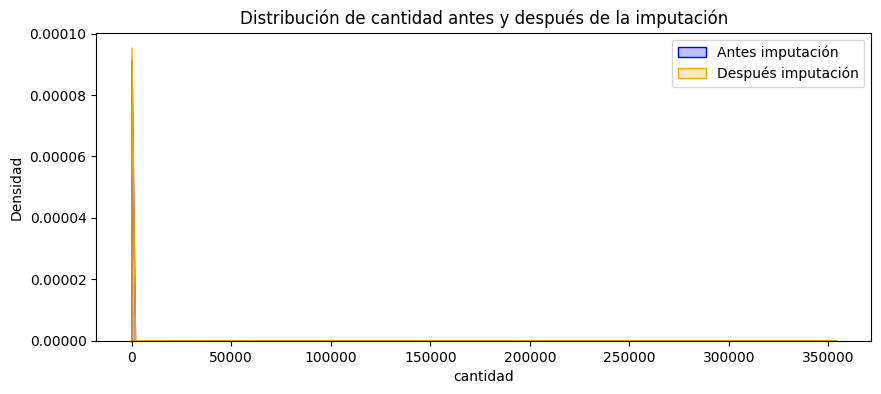

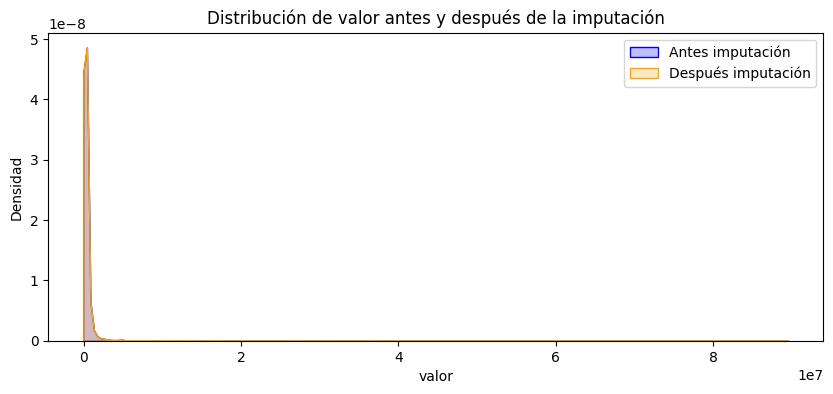

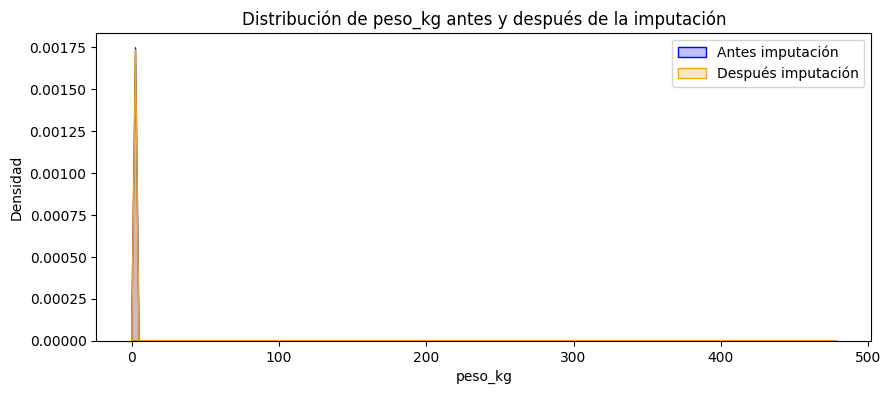

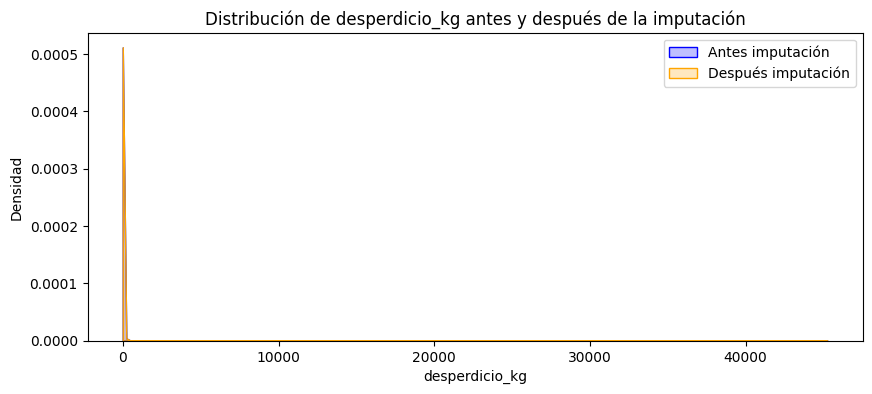

In [150]:
# Comparar distribuciones antes y después de la imputación
variables = ['cantidad', 'valor', 'peso_kg', 'desperdicio_kg']  # Ajusta según tus variables

for var in variables:
    plt.figure(figsize=(10,4))
    
    # Distribución antes de la imputación
    sns.kdeplot(df[var], label='Antes imputación', color='blue', fill=True)
    
    # Distribución después de la imputación
    sns.kdeplot(df_imput6[var], label='Después imputación', color='orange', fill=True)
    
    plt.title(f'Distribución de {var} antes y después de la imputación')
    plt.xlabel(var)
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()


A simple vista desde las gráficas se puede ver que no se modificó en gran medida las distribuciones.

In [154]:
# Estadísticas antes y después
for var in variables:
    print(f"\nVariable: {var}")
    print("Antes de imputación:")
    print(df[var].describe())
    print("Después de imputación:")
    print(df_imput6[var].describe())



Variable: peso_kg
Antes de imputación:
count    1.684739e+06
mean     5.732544e-01
std      6.381003e-01
min      1.000000e-02
25%      2.500000e-01
50%      4.500000e-01
75%      6.400000e-01
max      4.781000e+02
Name: peso_kg, dtype: float64
Después de imputación:
count    1.686017e+06
mean     5.732574e-01
std      6.379359e-01
min      1.000000e-02
25%      2.500000e-01
50%      4.500000e-01
75%      6.400000e-01
max      4.781000e+02
Name: peso_kg, dtype: float64

Variable: desperdicio_kg
Antes de imputación:
count    1.685496e+06
mean     3.607595e+00
std      4.155332e+01
min      2.500000e-05
25%      5.000000e-01
50%      1.200000e+00
75%      3.000000e+00
max      4.524580e+04
Name: desperdicio_kg, dtype: float64
Después de imputación:
count    1.686017e+06
mean     3.606544e+00
std      4.154694e+01
min      2.500000e-05
25%      5.000000e-01
50%      1.200000e+00
75%      3.000000e+00
max      4.524580e+04
Name: desperdicio_kg, dtype: float64


✅ Interpretación del resultado
1. Aumento en el count
El número de datos pasó de 1,684,739 → 1,686,017. Esto significa que se imputaron 1.278 valores faltantes (se agregaron valores donde había NaN).

2. La media y mediana casi no cambiaron
La media pasó de 0.5732544 → 0.5732574, un cambio mínimo. La mediana (50%), cuartiles y el mínimo/máximo se mantuvieron iguales.

👉 Esto indica que la imputación no deformó la distribución original. El método conservó la estructura estadística del dato.

3. Lo mismo aplica para desperdicio_kg
Solo se aumentó el count al imputar los NaN.
Los valores estadísticos esenciales (mediana, cuartiles, min, max) se mantuvieron casi iguales.


In [ ]:
# Comparar proporciones de categorías antes y después de la imputación
# Crear tabla de contingencia
tabla = pd.concat([prop_before, prop_after], axis=1).fillna(0)
tabla.columns = ['Antes', 'Después']

# Chi-cuadrado
chi2, p, dof, ex = chi2_contingency(tabla.T)
print(f"Chi-cuadrado: {chi2:.4f}, p-valor: {p:.4f}")



Chi-cuadrado: 0.0000, p-valor: 1.0000


✅ Interpretación

Chi-cuadrado = 0.0000
Significa que no hay diferencia entre las distribuciones de las categorías “Antes” y “Después”. Los valores observados coinciden exactamente con los esperados bajo la hipótesis nula.

p-valor = 1.0000
Es muy alto, mucho mayor que cualquier umbral típico (0.05, 0.01). Esto indica que no se rechaza la hipótesis nula, es decir, estadísticamente no hay diferencia entre las dos tablas.

# *Transformación de datos*

Transformación logarítmica variables discretas.

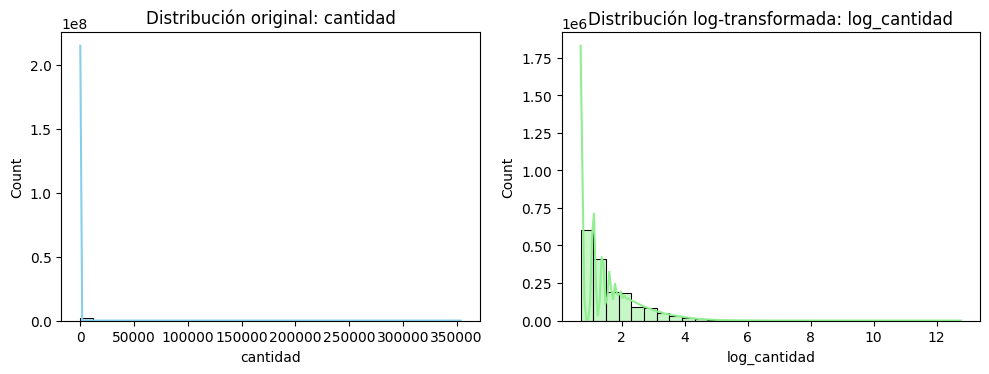

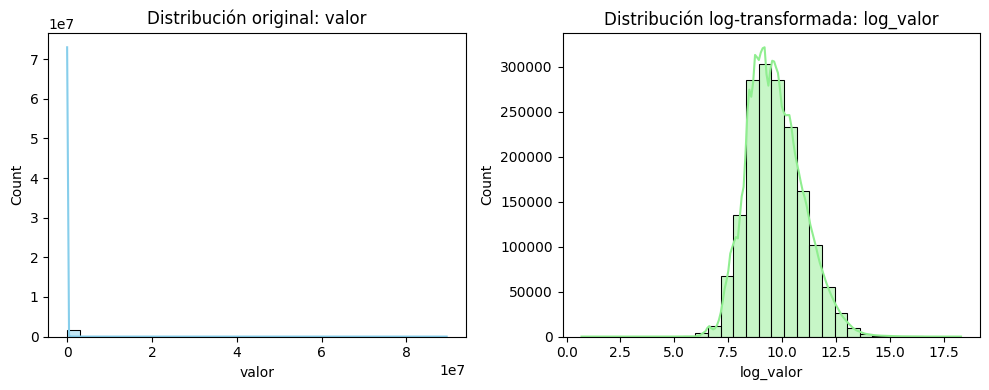

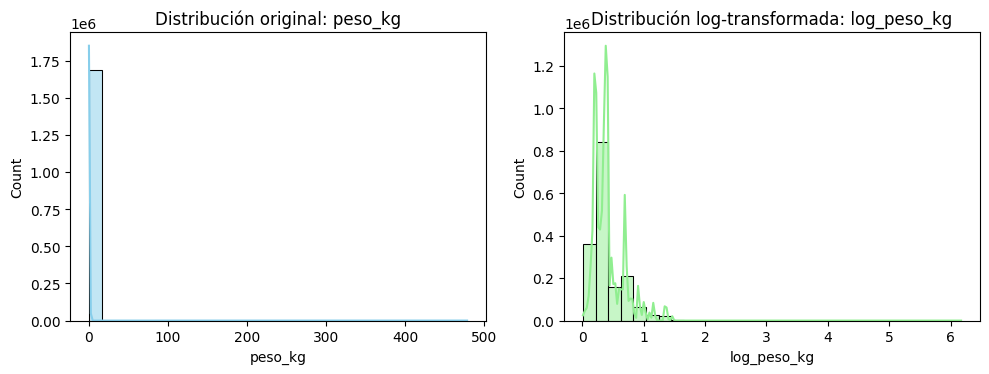

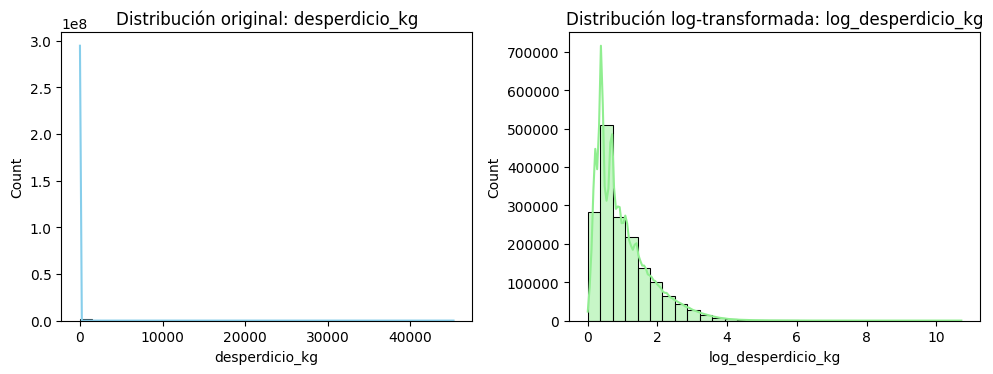

In [ ]:
#==============================
# Transformación Logarítmica
#==============================
#🧮 Paso 1. Aplicar la transformación logarítmica

variables = ["cantidad", "valor", "peso_kg", "desperdicio_kg"]

# Crear nuevas columnas transformadas
for var in variables:
    df_imput6[f"log_{var}"] = np.log1p(df_imput6[var])

# 📊 Paso 2. Validar si la transformación funcionó

for var in variables:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    sns.histplot(df_imput6[var], bins=30, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"Distribución original: {var}")
    
    sns.histplot(df_imput6[f"log_{var}"], bins=30, kde=True, ax=axes[1], color='lightgreen')
    axes[1].set_title(f"Distribución log-transformada: log_{var}")
    
    plt.tight_layout()
    plt.show()




In [160]:
#🧮 Paso 3. Calcular asimetría antes y después
for var in variables:
    original_skew = skew(df_imput6[var].dropna())
    log_skew = skew(df_imput6[f"log_{var}"].dropna())
    print(f"{var:12} -> Asimetría original: {original_skew:.2f} | log: {log_skew:.2f}")

cantidad     -> Asimetría original: 334.77 | log: 1.42
valor        -> Asimetría original: 127.86 | log: 0.42
peso_kg      -> Asimetría original: 273.98 | log: 1.57
desperdicio_kg -> Asimetría original: 808.26 | log: 1.43


Según los resultados, se puede decir que:

Original: todas las variables tienen asimetrías muy grandes (>100 en algunos casos), lo que indica distribuciones extremadamente sesgadas y con outliers muy grandes.

Logarítmica: después de aplicar log:

La asimetría se reduce drásticamente (ej. cantidad pasó de 334 → 1.42)

Las variables todavía tienen un ligero sesgo positivo, pero mucho más manejable.

Esto significa que la transformación logarítmica “normaliza” o aproxima la distribución hacia algo más simétrico, lo cual es útil para análisis estadísticos que requieren normalidad, como ANOVA, regresión o clustering.

In [162]:
#🧮 Paso 4. Prueba de normalidad KS antes y después
for var in variables:
    data_orig = df_imput6[var].dropna()
    data_log = df_imput6[f"log_{var}"].dropna()

    # Normalizamos (media 0, varianza 1) para hacer la prueba correctamente
    data_orig_std = (data_orig - data_orig.mean()) / data_orig.std()
    data_log_std = (data_log - data_log.mean()) / data_log.std()

    ks_orig = kstest(data_orig_std, 'norm')
    ks_log = kstest(data_log_std, 'norm')

    print(f"{var:12} -> p-valor original: {ks_orig.pvalue:.4f} | log: {ks_log.pvalue:.4f}")


cantidad     -> p-valor original: 0.0000 | log: 0.0000
valor        -> p-valor original: 0.0000 | log: 0.0000
peso_kg      -> p-valor original: 0.0000 | log: 0.0000
desperdicio_kg -> p-valor original: 0.0000 | log: 0.0000


🔹 Observaciones importantes:

✅ 3️⃣ Conclusión general

La transformación logarítmica redujo sustancialmente la asimetría de todas las variables, especialmente cantidad y valor, haciendo que las distribuciones sean más cercanas a la simetría y más adecuadas para análisis estadísticos basados en supuestos de normalidad.

Sin embargo:

Aunque mejoró la forma, los datos todavía no son completamente normales (como mostró el test KS).

Esto es normal en datos económicos, productivos o de demanda (con colas largas).

Pero ahora los datos son más tratables: puedes usar estos log-transformados para modelos lineales, ANOVA, o clustering sin violar tanto los supuestos.

# Transformación BOX COX variables discretas.

In [ ]:

#🧮 Aplicar la transformación Box-Cox
variables = ["cantidad", "valor", "peso_kg", "desperdicio_kg"]

# Copiamos el DataFrame para no modificar el original
df_boxcox = df_imput6.copy()

# Aplicar Box-Cox a cada variable
lambdas = {}  # Guardará los valores de λ encontrados

for var in variables:
    data = df_boxcox[var].dropna()
    
    # Si hay valores <= 0, desplazamos
    if (data <= 0).any():
        shift = abs(data.min()) + 1
        data = data + shift
    else:
        shift = 0
    
    # Aplicar Box–Cox
    transformed, fitted_lambda = boxcox(data)
    df_boxcox.loc[data.index, f"boxcox_{var}"] = transformed
    lambdas[var] = (fitted_lambda, shift)

# Mostrar lambdas encontrados
for var, (lam, shift) in lambdas.items():
    print(f"{var:12} -> λ = {lam:.4f} | desplazamiento = {shift}")


cantidad     -> λ = -0.4103 | desplazamiento = 0
valor        -> λ = -0.1083 | desplazamiento = 0
peso_kg      -> λ = -0.0222 | desplazamiento = 0
desperdicio_kg -> λ = -0.0926 | desplazamiento = 0


El análisis de la transformación de Box-Cox sobre las variables muestra que los valores de λ son cercanos a cero o negativos pequeños, lo que indica que las distribuciones presentan asimetría positiva moderada y que se benefician de una ligera transformación logarítmica para acercarse a la normalidad.

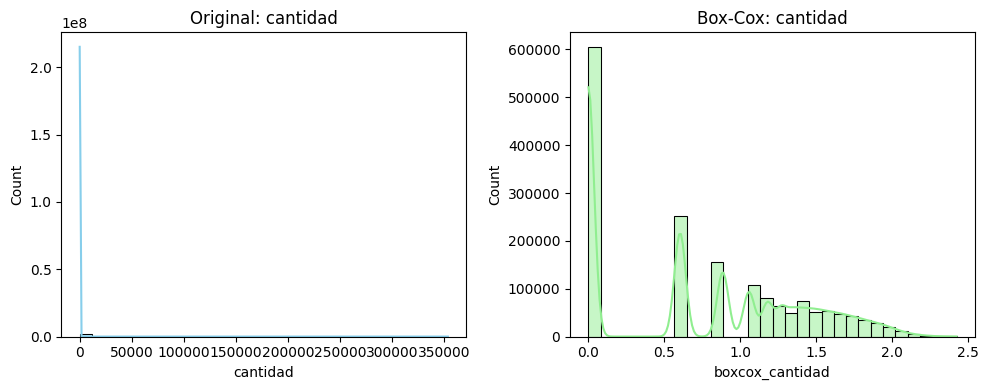

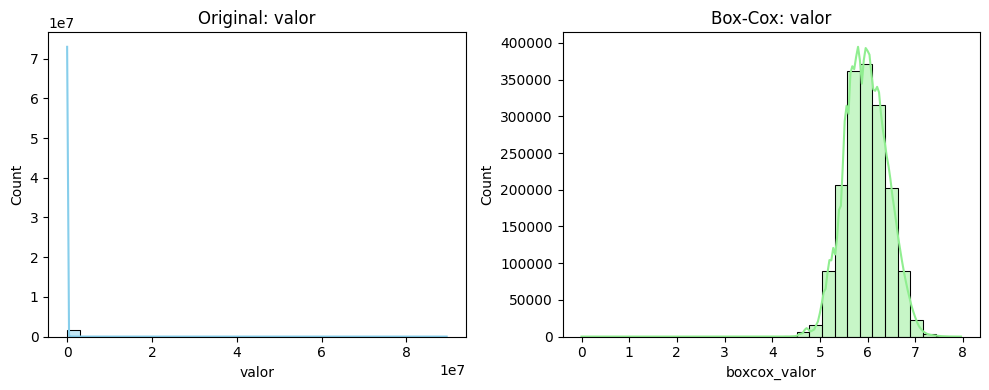

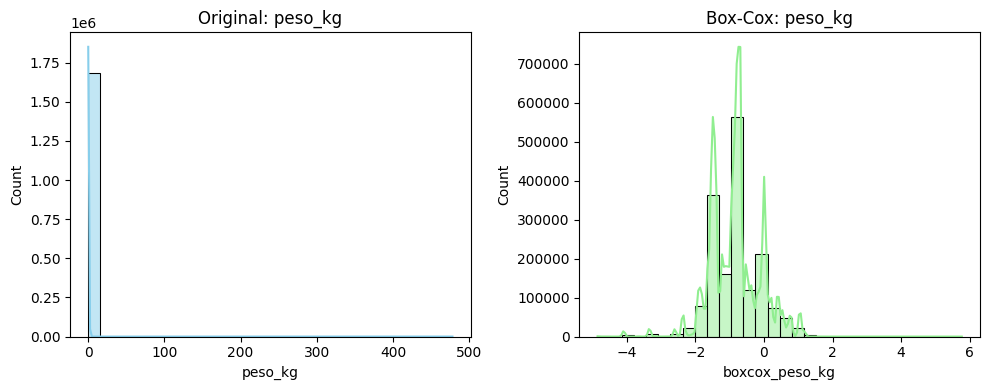

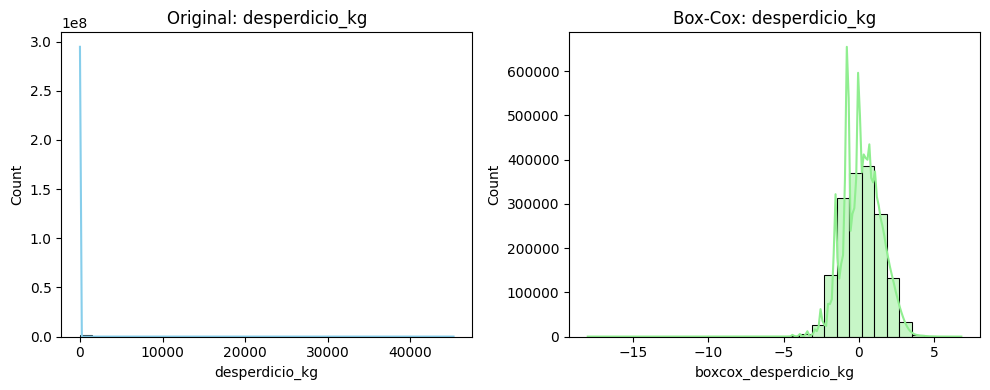

In [166]:
# 📊 Validar distribuciones antes y después de Box-Cox
for var in variables:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    sns.histplot(df_boxcox[var], bins=30, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"Original: {var}")
    
    sns.histplot(df_boxcox[f'boxcox_{var}'], bins=30, kde=True, ax=axes[1], color='lightgreen')
    axes[1].set_title(f"Box-Cox: {var}")
    
    plt.tight_layout()
    plt.show()


Validaciones de los datos antes y después de aplicar Box-Cox

In [ ]:
# 📊 Validar asimetría antes y después de Box-Cox
from scipy.stats import skew

for var in variables:
    s1 = skew(df_boxcox[var].dropna())
    s2 = skew(df_boxcox[f'boxcox_{var}'].dropna())
    print(f"{var:12} -> Asimetría original: {s1:.2f} | Box-Cox: {s2:.2f}")


cantidad     -> Asimetría original: 334.77 | Box-Cox: 0.21
valor        -> Asimetría original: 127.86 | Box-Cox: -0.00
peso_kg      -> Asimetría original: 273.98 | Box-Cox: -0.01
desperdicio_kg -> Asimetría original: 808.26 | Box-Cox: -0.01


In [ ]:
# 📊 Validar normalidad antes y después de Box-Cox
for var in variables:
    data_orig = df_boxcox[var].dropna()
    data_boxcox = df_boxcox[f'boxcox_{var}'].dropna()
    
    # Estandarizar
    data_orig_std = (data_orig - data_orig.mean()) / data_orig.std()
    data_boxcox_std = (data_boxcox - data_boxcox.mean()) / data_boxcox.std()
    
    ks_orig = kstest(data_orig_std, 'norm')
    ks_boxcox = kstest(data_boxcox_std, 'norm')
    
    print(f"{var:12} -> p-valor original: {ks_orig.pvalue:.4f} | Box-Cox: {ks_boxcox.pvalue:.4f}")


cantidad     -> p-valor original: 0.0000 | Box-Cox: 0.0000
valor        -> p-valor original: 0.0000 | Box-Cox: 0.0000
peso_kg      -> p-valor original: 0.0000 | Box-Cox: 0.0000
desperdicio_kg -> p-valor original: 0.0000 | Box-Cox: 0.0000


_**Comparación entre las dos transformaciones Log y BoxCox**_

El análisis de las variables muestra que todas presentan una **asimetría original muy alta**, especialmente `desperdicio_kg` y `cantidad`, indicando distribuciones fuertemente sesgadas hacia la derecha. La transformación de Box-Cox logra **reducir parcialmente la asimetría** en algunas variables (por ejemplo, `cantidad` pasa de 334.77 a 0.21), pero los valores de λ cercanos a cero o negativos indican que los efectos son modestos en otras variables. La prueba de normalidad de Kolmogorov-Smirnov confirma que, incluso después de la transformación, **ninguna variable sigue una distribución normal** (p-valor = 0.0000), por lo que se mantiene la no normalidad de los datos.


Al comparar las dos transformaciones aplicadas a las variables, se observa que tanto **el logaritmo** como **Box-Cox** buscan reducir la fuerte asimetría presente originalmente, pero con diferentes grados de efectividad.

* Para `cantidad`, la asimetría original era extremadamente alta (334.77); el logaritmo la reduce drásticamente a 1.42, mientras que Box-Cox la lleva a 0.21, mostrando que **Box-Cox logra una distribución más cercana a la simetría**.
* Para `valor`, `peso_kg` y `desperdicio_kg`, ambas transformaciones reducen la asimetría considerablemente respecto al original, pero Box-Cox produce valores de asimetría ligeramente menores o más cercanos a cero, indicando **un mejor ajuste para aproximarse a simetría**.

Sin embargo, las pruebas de normalidad de Kolmogorov-Smirnov muestran que **ninguna transformación logra normalidad perfecta** (p-valor = 0.0000 en todos los casos), por lo que aunque las transformaciones mejoran la distribución, los datos **siguen siendo no normales**, y los métodos estadísticos que asumen normalidad deberán aplicarse con precaución o considerar alternativas robustas.

En resumen: **logaritmo es simple y efectivo**, mientras que **Box-Cox logra un ajuste más cercano a la simetría**, aunque ninguna garantiza normalidad completa.


# Transformación variables categóricas.

In [ ]:
# Análisis de variables categóricas específicas
# Lista de variables categóricas específicas que quieres analizar
variables_especificas = ['material', 'subcategoria', 'categoria', 'planta', 'linea', 'marca', 'demanda']

# Crear un resumen con conteo de valores únicos solo para estas columnas
resumen_unicos = pd.DataFrame({
    'Variable': variables_especificas,
    'Cantidad Valores Únicos': [df_imput6[col].nunique() for col in variables_especificas]
})

# Ordenar de mayor a menor según cantidad de valores únicos
resumen_unicos = resumen_unicos.sort_values(by='Cantidad Valores Únicos', ascending=False).reset_index(drop=True)

# Mostrar resultado
print(resumen_unicos)



       Variable  Cantidad Valores Únicos
0      material                     1256
1         linea                       57
2  subcategoria                       30
3        planta                       20
4     categoria                       14
5         marca                       13
6       demanda                        5


In [ ]:
##==============================
# Codificación de Variables Categóricas
#==============================
# Hacer una copia del dataframe para no modificar el original
df_encoded = df_imput6.copy()

print("Dimensiones iniciales de df_imput6:", df_imput6.shape)

# 1. One Hot Encoding para: demanda, categoria, planta, marca
print("\n=== Aplicando One Hot Encoding ===")
variables_onehot = ['demanda', 'categoria', 'planta', 'marca']

for variable in variables_onehot:
    print(f"Aplicando One Hot Encoding a: {variable}")
    
    # Crear el encoder
    ohe = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar multicolinealidad
    
    # Aplicar la transformación
    encoded_array = ohe.fit_transform(df_encoded[[variable]])
    
    # Crear nombres para las nuevas columnas
    feature_names = ohe.get_feature_names_out([variable])
    
    # Crear DataFrame con las nuevas columnas
    encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df_encoded.index)
    
    # Concatenar con el dataframe original y eliminar la columna original
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    df_encoded.drop(columns=[variable], inplace=True)
    
    print(f"  - Se crearon {len(feature_names)} nuevas columnas para {variable}")

# 2. Count Encoding para: subcategoria, linea, material
print("\n=== Aplicando Count Encoding ===")
variables_count = ['subcategoria', 'linea', 'material']

for variable in variables_count:
    print(f"Aplicando Count Encoding a: {variable}")
    
    # Calcular las frecuencias
    count_encoding = df_encoded[variable].value_counts().to_dict()
    
    # Aplicar el mapeo
    df_encoded[f'{variable}_count'] = df_encoded[variable].map(count_encoding)
    
    # Opcional: eliminar la columna original si solo quieres mantener la codificación
    # df_encoded.drop(columns=[variable], inplace=True)
    
    print(f"  - Valores únicos en {variable}: {len(count_encoding)}")

# Verificar el resultado final
print("\n=== Resultado Final ===")
print(f"Dimensiones del dataframe transformado: {df_encoded.shape}")
print(f"\nVariables originales: {df_imput6.shape[1]}")
print(f"Variables después de transformación: {df_encoded.shape[1]}")
print(f"\nNuevas columnas creadas:")

# Mostrar las nuevas columnas
new_columns = [col for col in df_encoded.columns if col not in df_imput6.columns]
print(f"Total nuevas columnas: {len(new_columns)}")
for i, col in enumerate(new_columns[:20]):  # Mostrar primeras 20 columnas
    print(f"  {i+1}. {col}")

if len(new_columns) > 20:
    print(f"  ... y {len(new_columns) - 20} columnas más")

# Mostrar información del dataframe resultante
print("\n=== Información del DataFrame Transformado ===")
print(df_encoded.info())

# Mostrar primeras filas para verificar
print("\n=== Primeras filas del DataFrame Transformado ===")
print(df_encoded.head())

Dimensiones iniciales de df_imput6: (1686017, 18)

=== Aplicando One Hot Encoding ===
Aplicando One Hot Encoding a: demanda
  - Se crearon 4 nuevas columnas para demanda
Aplicando One Hot Encoding a: categoria
  - Se crearon 13 nuevas columnas para categoria
Aplicando One Hot Encoding a: planta
  - Se crearon 19 nuevas columnas para planta
Aplicando One Hot Encoding a: marca
  - Se crearon 12 nuevas columnas para marca

=== Aplicando Count Encoding ===
Aplicando Count Encoding a: subcategoria
  - Valores únicos en subcategoria: 30
Aplicando Count Encoding a: linea
  - Valores únicos en linea: 57
Aplicando Count Encoding a: material
  - Valores únicos en material: 1256

=== Resultado Final ===
Dimensiones del dataframe transformado: (1686017, 65)

Variables originales: 18
Variables después de transformación: 65

Nuevas columnas creadas:
Total nuevas columnas: 51
  1. demanda_d. ordinaria
  2. demanda_lv extraordinaria
  3. demanda_lv ordinaria
  4. demanda_no aplica
  5. categoria_alime

Unificar dataframe final, con las transformaciones Box-Cox, Count Encoding y One Hot Encoding.

In [174]:
# Crear df_final unificando todas las transformaciones
print("=== CREANDO DF_FINAL UNIFICADO ===")

# 1. Primero verificar qué tenemos en cada dataframe
print("Dimensiones df_encoded:", df_encoded.shape)
print("Dimensiones df_boxcox:", df_boxcox.shape)
print("Variables en df_original:", list(df.columns))

# 2. Seleccionar solo las transformaciones específicas de df_encoded
variables_encoded = ['demanda', 'categoria', 'planta', 'marca', 'subcategoria', 'linea', 'material']

# Identificar las columnas transformadas de estas variables
columnas_encoded = []
for var in variables_encoded:
    # Buscar columnas relacionadas con cada variable
    columnas_var = [col for col in df_encoded.columns if var in col]
    columnas_encoded.extend(columnas_var)
    print(f"Columnas de {var}: {columnas_var}")

print(f"\nTotal columnas de encoding: {len(columnas_encoded)}")

# 3. Seleccionar las variables continuas transformadas de df_boxcox
variables_boxcox = ["cantidad", "valor", "peso_kg", "desperdicio_kg"]
columnas_boxcox = [col for col in df_boxcox.columns if any(var in col for var in variables_boxcox)]

print(f"Columnas de boxcox: {columnas_boxcox}")
print(f"Total columnas de boxcox: {len(columnas_boxcox)}")

# 4. Agregar la variable 'tipo' del df original
if 'tipo' in df.columns:
    print(f"\nVariable 'tipo' encontrada en df_original")
    # Verificar si tenemos los mismos índices
    print(f"Longitud de 'tipo': {len(df['tipo'])}")
else:
    print("Variable 'tipo' no encontrada en df_original")

# 5. Crear df_final
df_final = pd.DataFrame(index=df_encoded.index)

# Agregar transformaciones de encoding
print("\nAgregando transformaciones de encoding...")
for col in columnas_encoded:
    if col in df_encoded.columns:
        df_final[col] = df_encoded[col]
        print(f"✓ {col}")

# Agregar transformaciones de boxcox
print("\nAgregando transformaciones de boxcox...")
for col in columnas_boxcox:
    if col in df_boxcox.columns:
        # Asegurarnos de que los índices coincidan
        df_final[col] = df_boxcox[col].values
        print(f"✓ {col}")

# Agregar variable 'tipo'
if 'tipo' in df.columns:
    # Verificar y ajustar índices si es necesario
    if len(df) == len(df_final):
        df_final['tipo'] = df['tipo'].values
        print(f"✓ tipo")
    else:
        print("¡Advertencia: Los dataframes tienen diferentes longitudes!")
        print(f"df_original: {len(df)} filas")
        print(f"df_final: {len(df_final)} filas")
        
        # Si hay diferencia, hacer merge por índice
        df_final = df_final.merge(df[['tipo']], left_index=True, right_index=True, how='left')
        print("✓ tipo (merged por índice)")

# 6. Verificar el resultado final
print("\n" + "="*50)
print("RESUMEN DF_FINAL")
print("="*50)
print(f"Dimensiones finales: {df_final.shape}")
print(f"Columnas totales: {len(df_final.columns)}")
print(f"\nTipos de datos en df_final:")
print(df_final.dtypes.value_counts())

print(f"\nPrimeras 10 columnas:")
print(df_final.columns[:10].tolist())

print(f"\nPrimeras 5 filas:")
print(df_final.head())

# 7. Información detallada por categoría de variables
print(f"\n=== DISTRIBUCIÓN DE VARIABLES EN DF_FINAL ===")
encoding_cols = [col for col in df_final.columns if any(var in col for var in variables_encoded)]
boxcox_cols = [col for col in df_final.columns if any(var in col for var in variables_boxcox)]
tipo_col = ['tipo'] if 'tipo' in df_final.columns else []

print(f"Variables de encoding: {len(encoding_cols)}")
print(f"Variables de boxcox: {len(boxcox_cols)}")
print(f"Variables originales (tipo): {len(tipo_col)}")
print(f"Total: {len(encoding_cols) + len(boxcox_cols) + len(tipo_col)}")

# 8. Guardar información del proceso
print(f"\n=== PROCESO COMPLETADO ===")
print(f"✅ df_final creado exitosamente")
print(f"✅ Dimensiones: {df_final.shape}")
print(f"✅ Variables incluidas: {len(df_final.columns)}")

=== CREANDO DF_FINAL UNIFICADO ===
Dimensiones df_encoded: (1686017, 65)
Dimensiones df_boxcox: (1686017, 22)
Variables en df_original: ['fecha', 'material', 'cantidad', 'valor', 'peso_kg', 'desperdicio_kg', 'planta', 'categoria', 'subcategoria', 'linea', 'marca', 'demanda', 'tipo', 'nombre_material']
Columnas de demanda: ['demanda_d. ordinaria', 'demanda_lv extraordinaria', 'demanda_lv ordinaria', 'demanda_no aplica']
Columnas de categoria: ['subcategoria', 'categoria_alimentos larga vida', 'categoria_amarres especiales', 'categoria_analogos carnicos', 'categoria_bebidas refrescantes', 'categoria_cafe', 'categoria_carnes frescas', 'categoria_carnes frias', 'categoria_champinones', 'categoria_galletas', 'categoria_otros distribuidos', 'categoria_pescados y mariscos', 'categoria_platos preparados', 'categoria_subproductos', 'subcategoria_count']
Columnas de planta: ['planta_barranquilla', 'planta_bogota', 'planta_caloto', 'planta_cd regional barranquilla alcar', 'planta_cd regional bogo

Exportar Data tipo CSV

In [175]:
# Exportar df_final a CSV
print("=== EXPORTANDO DF_FINAL A CSV ===")

# 1. Verificar el dataframe final
print(f"Dimensiones de df_final: {df_final.shape}")
print(f"Columnas: {len(df_final.columns)}")
print(f"Primeras 5 columnas: {df_final.columns[:5].tolist()}")

# 2. Exportar a CSV
nombre_archivo = "df_final.csv"

try:
    df_final.to_csv(nombre_archivo, index=True, encoding='utf-8')
    print(f"✅ Archivo exportado exitosamente: {nombre_archivo}")
    print(f"✅ Tamaño del dataframe: {df_final.shape}")
    print(f"✅ Columnas exportadas: {len(df_final.columns)}")
    
except Exception as e:
    print(f"❌ Error al exportar: {e}")
    # Intentar con diferentes parámetros si hay error
    try:
        df_final.to_csv(nombre_archivo, index=True, encoding='utf-8', errors='ignore')
        print(f"✅ Archivo exportado con parámetros alternativos: {nombre_archivo}")
    except Exception as e2:
        print(f"❌ Error persistente: {e2}")

# 3. Verificar que el archivo se creó correctamente
import os
if os.path.exists(nombre_archivo):
    file_size = os.path.getsize(nombre_archivo) / 1024 / 1024  # Tamaño en MB
    print(f"✅ Archivo creado: {nombre_archivo}")
    print(f"✅ Tamaño del archivo: {file_size:.2f} MB")
    
    # Leer una muestra del archivo para verificar
    try:
        # Leer solo las primeras filas para verificar
        df_verificacion = pd.read_csv(nombre_archivo, nrows=5)
        print(f"✅ Archivo verificado - Dimensiones: {df_verificacion.shape}")
        print("\nPrimeras 3 filas del archivo exportado:")
        print(df_verificacion.head(3))
    except Exception as e:
        print(f"⚠️  Archivo creado pero hubo error al verificar: {e}")
else:
    print("❌ El archivo no se creó correctamente")

# 4. Información adicional del export
print("\n" + "="*50)
print("INFORMACIÓN DE EXPORTACIÓN")
print("="*50)
print(f"📊 Total de filas exportadas: {len(df_final):,}")
print(f"📊 Total de columnas exportadas: {len(df_final.columns)}")
print(f"💾 Archivo: {nombre_archivo}")
print(f"📁 Ubicación: {os.path.abspath(nombre_archivo)}")

=== EXPORTANDO DF_FINAL A CSV ===
Dimensiones de df_final: (1686017, 68)
Columnas: 68
Primeras 5 columnas: ['demanda_d. ordinaria', 'demanda_lv extraordinaria', 'demanda_lv ordinaria', 'demanda_no aplica', 'subcategoria']
✅ Archivo exportado exitosamente: df_final.csv
✅ Tamaño del dataframe: (1686017, 68)
✅ Columnas exportadas: 68
✅ Archivo creado: df_final.csv
✅ Tamaño del archivo: 745.82 MB
✅ Archivo verificado - Dimensiones: (5, 69)

Primeras 3 filas del archivo exportado:
   Unnamed: 0  demanda_d. ordinaria  demanda_lv extraordinaria  \
0           0                   0.0                        0.0   
1           1                   0.0                        0.0   
2           2                   0.0                        0.0   

   demanda_lv ordinaria  demanda_no aplica                   subcategoria  \
0                   1.0                0.0  amarres especiales larga vida   
1                   1.0                0.0  amarres especiales larga vida   
2                   1.0

# **8. Conclusiones**

CRISP-DM permitió identificar problemas ocultos en la calidad de los datos, como destrucciones con valores negativos y códigos de producto “0”, evidenciando la importancia del contexto y del preprocesamiento para evitar sesgos en los modelos.

Las técnicas aplicadas mejoraron la estructura del conjunto de datos: Cramer’s V redujo la dimensión categórica, Box-Cox mejoró la distribución de variables continuas y los métodos One Hot Encoding y Count Encoding permitieron una transformación coherente sin aumentar significativamente el tamaño de la data.

El análisis enfrentó limitaciones importantes, principalmente el gran volumen de registros, la alta proporción de variables categóricas y la necesidad de trabajar por separado las bases de donaciones y destrucciones, siendo esta última especialmente difícil de interpretar.

Se identificaron líneas futuras de investigación, como evaluar una variable respuesta categórica y explorar nuevas metodologías que permitan explicar mejor el comportamiento atípico y la falta de estructura en la data de destrucciones.








# **Referencias**

Akkaş, A., & Gaur, V. (2022). OM Forum—Reducing Food Waste: An Operations Management Research Agenda. Manufacturing & Service Operations Management, 24(3), 1261-1275. https://doi.org/10.1287/msom.2021.1044

Departamento Nacional de Planeación (DNP), Lineamientos para la formulación de la política pública para la reducción de pérdidas y desperdicios de alimentos en Colombia, 2016. Disponible: https://colaboracion.dnp.gov.co/CDT/Desarrollo%20Social/Lineamientos_Perde_Desperd_Alimentos.pdf